In [3]:
from torchvision import models, datasets, transforms

resnet_weights = models.ResNet50_Weights.DEFAULT
caltech256 = datasets.Caltech256(
    root="data",
    download=True,
    transform=transforms.ToTensor()
)
print(caltech256[15][0].shape)

Files already downloaded and verified
torch.Size([1, 180, 436])


In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
import torchvision
import numpy as np
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.13.1+cu116
Torchvision Version:  0.14.1+cu116


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
from torchvision import models
resnet_weights = models.ResNet50_Weights.DEFAULT
resnet = models.resnet50(weights=resnet_weights)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Take the transformations expected from the resnet model for usage when loading the new dataset.

**FRAGE: Ist das alles was notwendig ist damit die Bilder im richtigen Format vorliegen?**

In [4]:
preprocess = resnet_weights.transforms()
preprocess

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [5]:
preprocessB = transforms.Compose([transforms.Resize(256),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
preprocessB

Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

Load the dataset with the required preprocessing steps.

In [16]:
caltech256 = datasets.Caltech256(
    root="data",
    download=True,
    # transform=preprocess
    transform=transforms.ToTensor()
)
print('Caltech256 contains {} datapoints'.format(len(caltech256)))

Files already downloaded and verified
Caltech256 contains 30607 datapoints


In [18]:
caltech256[15][0].shape

RuntimeError: ignored

In [17]:
for i in range(len(caltech256)):
  print(i)
  print(caltech256[i][0].shape)

0
torch.Size([3, 224, 224])
1
torch.Size([3, 224, 224])
2
torch.Size([3, 224, 224])
3
torch.Size([3, 224, 224])
4
torch.Size([3, 224, 224])
5
torch.Size([3, 224, 224])
6
torch.Size([3, 224, 224])
7
torch.Size([3, 224, 224])
8
torch.Size([3, 224, 224])
9
torch.Size([3, 224, 224])
10
torch.Size([3, 224, 224])
11
torch.Size([3, 224, 224])
12
torch.Size([3, 224, 224])
13
torch.Size([3, 224, 224])
14
torch.Size([3, 224, 224])
15


RuntimeError: ignored

In [11]:
three_channel = torch.empty(3,224,224).shape
categories_to_keep = range(20)

n_samples_orig = len(caltech256)
print('Number of samples in original set: {}'.format(n_samples_orig))

valid_3_channel_samples = np.full((n_samples_orig,), True)
samples_with_categories_to_keep = np.full((n_samples_orig,), True)
for i in range(len(caltech256)):
  valid_3_channel_samples = caltech256[i][0].shape == three_channel
  samples_with_categories_to_keep = caltech256[i][1] in categories_to_keep

samples_to_keep = valid_3_channel_samples and samples_with_categories_to_keep
n_samples = samples_to_keep.sum()

print('Number of samples in reduced set: {}'.format(n_samples))

Number of samples in original set: 30607


AttributeError: ignored

In [62]:
caltech256[15][0].shape

torch.Size([1, 180, 436])

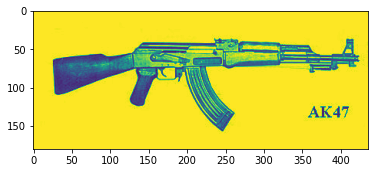

In [65]:
plt.imshow(caltech256[15][0].permute(1, 2, 0))

Randomly split the dataset into a training and a validation set with ratios 0.7/0.3.

In [6]:
from torch.utils.data import random_split
caltech256_train, caltech256_test = random_split(caltech256, [0.7,0.3])
print('Created training dataset containing {} datapoints'.format(len(caltech256_train)))
print('Created test dataset containing {} datapoints'.format(len(caltech256_test)))

Created training dataset containing 21425 datapoints
Created test dataset containing 9182 datapoints


Set some parameters for the training.

In [7]:
batch_size = 16
num_epochs = 15

Create the dataloaders.

In [8]:
train_dataloader = DataLoader(caltech256_train, batch_size=batch_size)
test_dataloader = DataLoader(caltech256_test, batch_size=batch_size)
print('Created training dataloader containing {} batches'.format(len(train_dataloader)))
print('Created test dataloader containing {} batches'.format(len(test_dataloader)))

Created training dataloader containing 1340 batches
Created test dataloader containing 574 batches


## Initializing the network 

In [ ]:
resnet.parameters

In the case that we are feature extracting, we want to freeze all but a few layers (here all expect for the last layer)

In [10]:
feature_extract = True
if feature_extract:
  for param in resnet.parameters():
    param.requires_grad = False

Extract the number of classes in the Caltech256 dataset. 

Adapt resnet to the target task by changing the last fully connected layer to the required number of outputs (and initializing the weights in the process). The last layer will hereby have 'requires_grad=True'. This is called feature extraction.

In [11]:
print('Previous resnet fully connnected layer')
print(resnet.fc)
# num_classes = len(caltech256.categories)
num_classes = len(catgories_to_keep)
print('num of classes: {}'.format(num_classes))
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
print('New resnet fully connnected layer')
print(resnet.fc)

Previous resnet fully connnected layer
Linear(in_features=2048, out_features=1000, bias=True)
num of classes: 257
New resnet fully connnected layer
Linear(in_features=2048, out_features=257, bias=True)


Collect all parameters that are to be updated.

In [12]:
params_to_update = resnet.parameters
print('Parameters to be updated')
if feature_extract:
    params_to_update = []
    for name,param in resnet.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in resnet.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Parameters to be updated
	 fc.weight
	 fc.bias


Send the model to the device.

In [13]:
resnet = resnet.to(device)

In [38]:
i = 0
for inputs, labels in train_dataloader:
  print(i)
  i = i+1
  inputs = inputs.to(device)
  labels = labels.to(device)
  print(inputs.shape)
  print(labels.shape)
  outputs = resnet(inputs)
  print(outputs.shape)
  print(outputs.argmax(dim=1).shape)
  if i == 3:
    break

0
torch.Size([16, 3, 224, 224])
torch.Size([16])
torch.Size([16, 257])
torch.Size([16])
1
torch.Size([16, 3, 224, 224])
torch.Size([16])
torch.Size([16, 257])
torch.Size([16])


RuntimeError: ignored

Set the optimizer to be used for the training. Here we use either SGD, Adam or AdamW.

In [21]:
sgd_parameters = {
    'lr':1e-3,        # undefined
    'momentum':0.1,   # 0
    'dampening':0,    # 0
    'weight_decay':0  # 0
}
optimizer = torch.optim.SGD(params_to_update, **sgd_parameters)

# adam_parameters = {
#     'lr':1e-3,            # 0.001
#     'betas':(0.9, 0.999), # (0.9, 0.999)
#     'eps':1e-08,          # 1e-08
#     'weight_decay':0      # 0
# }
# optimizer = torch.optim.Adam(params_to_update, **adam_parameters) # Adam
# optimizer = torch.optim.AdamW(params_to_update, **adam_parameters) # AdamW

Set the loss function.

In [22]:
label_smoothing = 0
loss_fn = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

Set the learning rate scheduler.

In [ ]:
# learning_rate_to_zero_in_number_of_epochs = 9999999
# scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.0, total_iters=learning_rate_to_zero_in_number_of_epochs)

Helper function for training.

In [35]:
def train_model(model, dataloaders, loss_fn, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                print(phase)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels)

                    # print(len(outputs))
                    preds = outputs.argmax(dim=1)
                    print(preds)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

Start training of the model.


In [36]:
resnet_finetuned, hist = train_model(resnet,
                                     {'train':train_dataloader,
                                       'test':test_dataloader},
                                     loss_fn,
                                     optimizer,
                                     num_epochs=num_epochs)

Epoch 0/14
----------
train
tensor([ 38, 250,  43,  73, 133, 241, 164,  16, 115, 105, 229,  93, 105, 103,
        133,  66], device='cuda:0')
train
tensor([ 25,  78, 146,  96, 204, 255, 181,  99, 206, 249,  50, 250,  28, 118,
        238, 157], device='cuda:0')


RuntimeError: ignored